In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
import pandas as pd
import datetime
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

# Information

In [3]:
path = '/kaggle/input/sf-dst-scoring/'

In [4]:
train = pd.read_csv(path +'/train.csv')
test = pd.read_csv(path +'test.csv')
sample = pd.read_csv(path +'/sample_submission.csv')

In [5]:
print(train.info())
print('Train size: ', train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [6]:
print(test.info())
print('Test size: ', train.shape)
test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [7]:
print(sample.info())
print(sample.shape)
sample.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None
(24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


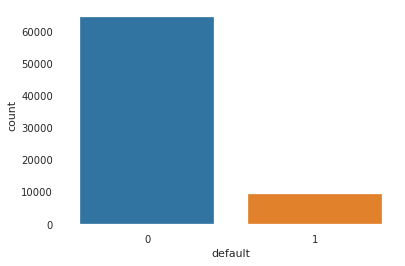

In [8]:
# Let's look at default count
plot = sns.countplot(train['default'])

Hmm.. there are way more clients who go into default

In [9]:
# Unite datasets to ease the preprocessing
train['sample'] = 1   # train
test['sample'] = 0    # test
test['default'] = -1  # imaginary value for now
data = train.append(test, sort=False).reset_index(drop=True)

In [10]:
print(data.info())
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

(110148, 20)

## *Data Description:*
client_id - identification

education - education level

sex - sex

age - age

car - binary/ has a car or not

car_type - whether car is international

decline_app_cnt - declined application count in the past

good_work - binary/ has 'good' work or not

bki_request_cnt - requests to BKI

home_address - category of home address

work_address - category of work address

income - income

foreign_passport - binary/ has foreign passport

sna - connection with bank employee

first_time - age of information about the client

score_bki - BKI score

region_rating - region rating

app_date - application date

default - default flag

# EDA

In [11]:
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating'] 
cat_cols = ['education','work_address','home_address','sna','first_time'] 
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] 

# *Numerical*

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


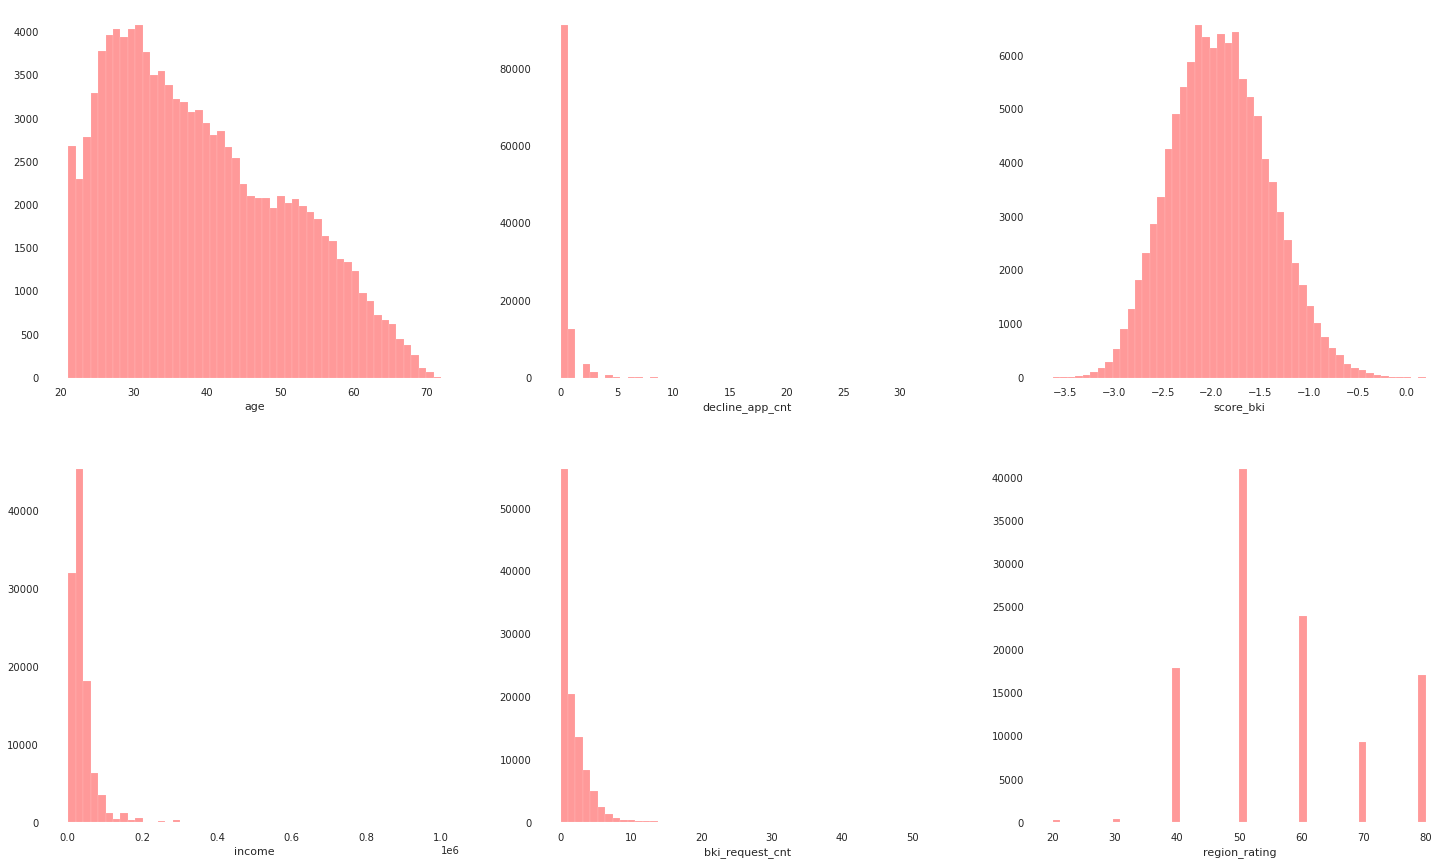

In [12]:
# Let's look at numerical data
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i,col in enumerate(num_cols):
    sns.distplot(data[col], kde=False, ax=axes.flat[i], color="r")

### Hmm.. distribution is skewed to the left for some variables, lets apply log function to them

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

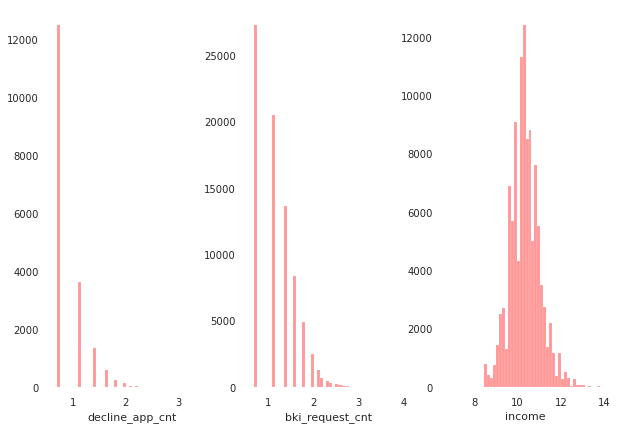

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10,7))
for i,col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    data[col] = np.log(data[col] + 1)
    sns.distplot(data[col][data[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False,color="r")
    
    

## We can notice some outliers, but the distribution is normal now

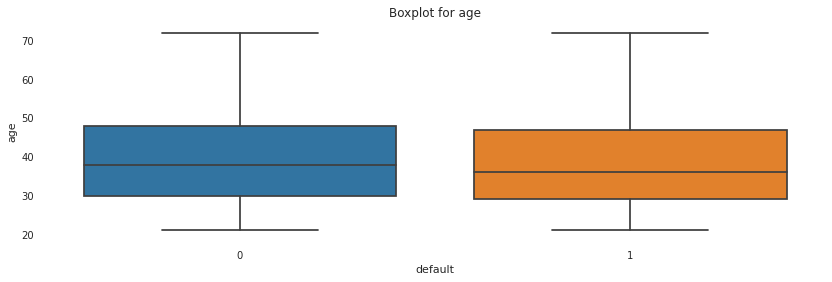

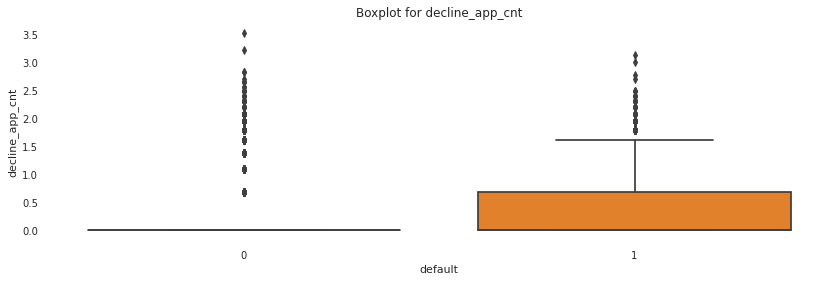

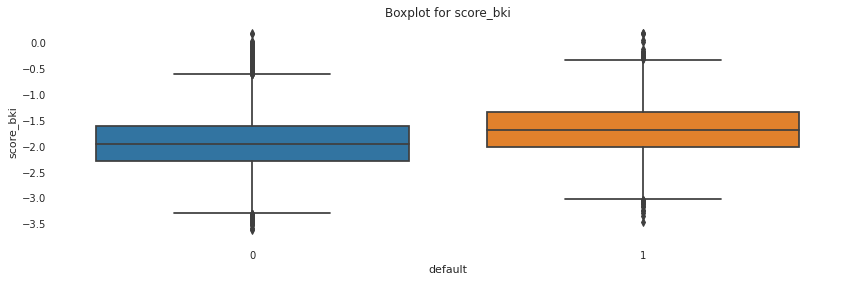

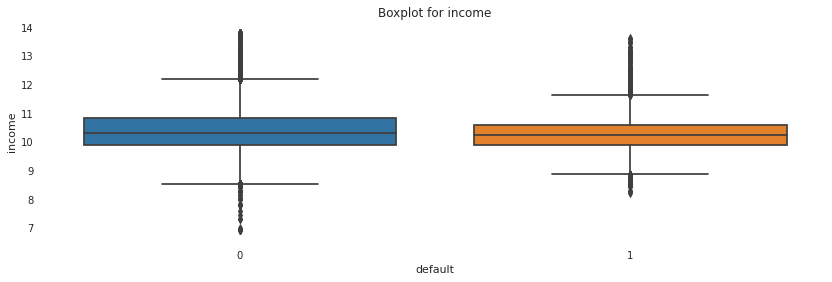

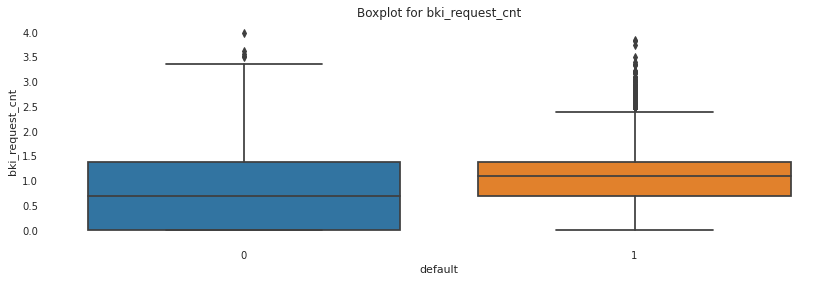

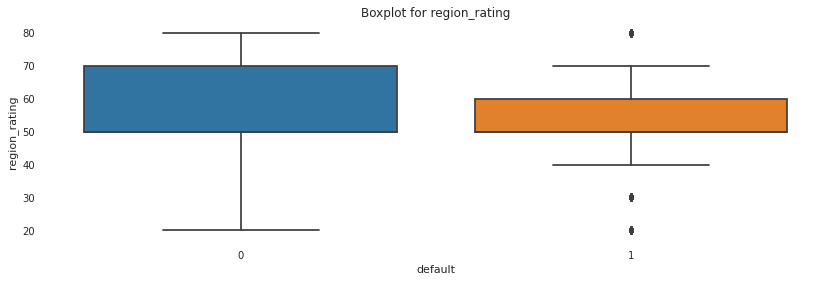

In [14]:
def boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=col, data=data[data['sample']==1],ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()
for col in num_cols:
    boxplot(col)

## What can we see here?

* people who do not default, generally, older.

* people who default have higher scoring.

* Region rating affects default.

* BKI requests are higher in people who do not default.

* On average, people who do not default have higher income.

# *Categorical*

Missing education values:
 478


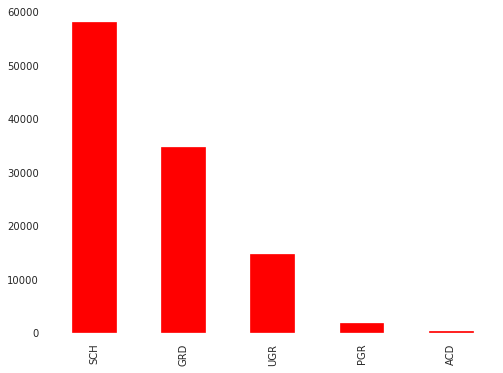

In [15]:
data.education.value_counts().plot(kind="bar",figsize=(8,6),color="r")
print("Missing education values:\n",data.education.isna().sum())

In [16]:
data.education = data.education.fillna("SCH") # replace with the most common

Смотрим зависимость дохода от уровня образования

<AxesSubplot:xlabel='education', ylabel='income'>

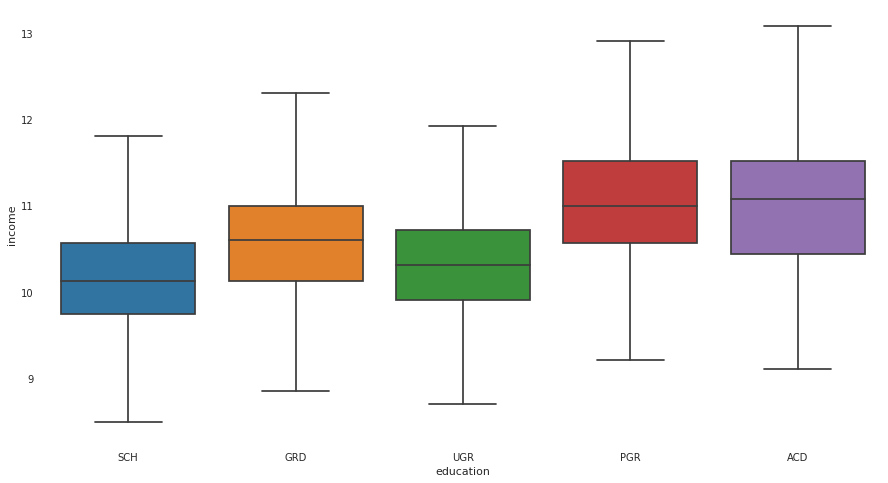

In [17]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="education", y="income", data=data, showfliers=False)

<AxesSubplot:>

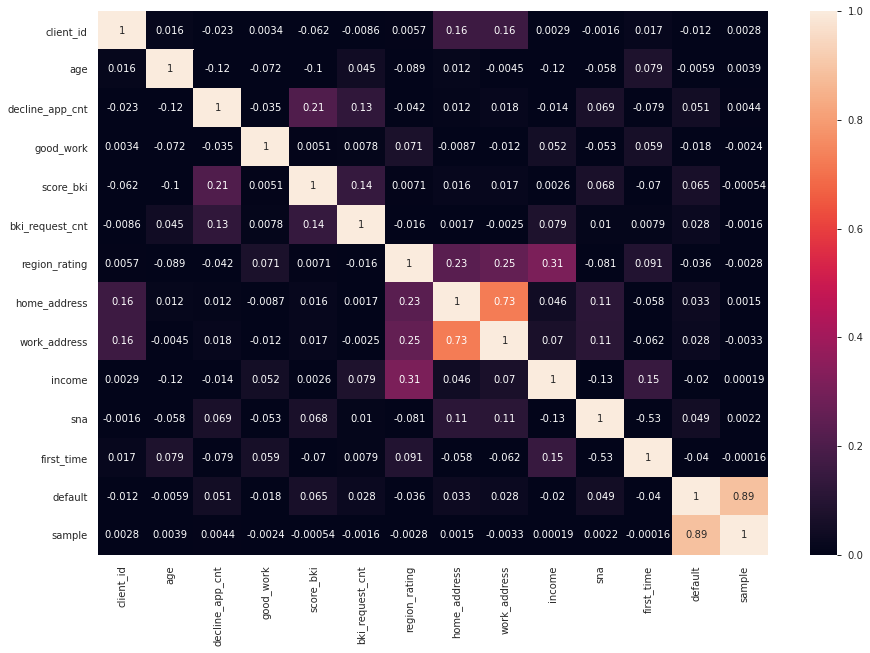

In [18]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=0, vmax=1, annot = True)

### We do not have any extreme multicollinerality

# *Feature engineering*

In [19]:
data['app_date'] = pd.to_datetime(data.app_date)
data['app_date'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days) # days from the first date

In [20]:
df = data.copy()

In [21]:
# mean income by age
mean_income = df.groupby('age')['income'].mean().to_dict()
df['mean_income_age'] = df['age'].map(mean_income)

In [22]:
# Max income by age
max_income = df.groupby('age')['income'].max().to_dict()
df['max_income_age'] = df['age'].map(max_income)

In [23]:
# and normalize it
df["normalized_income"] = abs((df.income - df.mean_income_age)/df.max_income_age)

In [24]:
# requests to BKI by age
mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
df['mean_requests_age'] = df['age'].map(mean_bki)

In [25]:
# mean BKI requests by income
mean_bki_inc = df.groupby('income')['bki_request_cnt'].mean().to_dict()
df['mean_requests_income'] = df['income'].map(mean_bki_inc)

In [26]:
# Mean income by region
mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

### Encoding

In [27]:
mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))

In [28]:
mappc = {}
enc = OneHotEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mappc[col] = dict(enumerate(label_encoder.classes_))


In [29]:
print(mapp)
print(mappc)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}
{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}, 'work_address': {0: 1, 1: 2, 2: 3}, 'home_address': {0: 1, 1: 2, 2: 3}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}


In [30]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample',
       'mean_income_age', 'max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region'],
      dtype='object')

In [31]:
# need to rename the columns
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','app_date', 'mean_income_age','region_rating','max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region'] # numerical
cat_cols = ['education','work_address','home_address','sna','first_time'] # categorical
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] # binary

### Now let's deal with the outliers

In [32]:
for col in num_cols:
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print("Columns: ", col)
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),"Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

Columns:  age
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].
Columns:  decline_app_cnt
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].
Columns:  score_bki
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].
Columns:  income
25%: 9.90353755128617, 75%: 10.778977123006351, IQR: 0.8754395717201806,  Borderline: [8.590378193705899, 12.092136480586621].
Columns:  bki_request_cnt
25%: 0.0, 75%: 1.3862943611198906, IQR: 1.3862943611198906,  Borderline: [-2.0794415416798357, 3.465735902799726].
Columns:  app_date
25%: 33.0, 75%: 89.0, IQR: 56.0,  Borderline: [-51.0, 173.0].
Columns:  mean_income_age
25%: 10.305358726970132, 75%: 10.444420558250247, IQR: 0.13906183128011484,  Borderline: [10.096765980049959, 10.653013305170418].
Columns:  region_rating
25%: 50.0, 75%: 60.0, IQR: 10.0,  Borderline: [35.0, 75.0].
Columns:  max_income_age
25%: 13.353476685668044, 75%: 13.81451105863119, IQR: 0.46103437296

No outliers anymore

## Scaling

In [33]:
df1 = df.copy()
dataset = df.copy()

In [34]:
dataset[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = df[num_cols].columns)


## Now let's see what features are useless

### ***Numerical***

In [35]:
data_temp = dataset.loc[data['sample'] == 1] 

<AxesSubplot:>

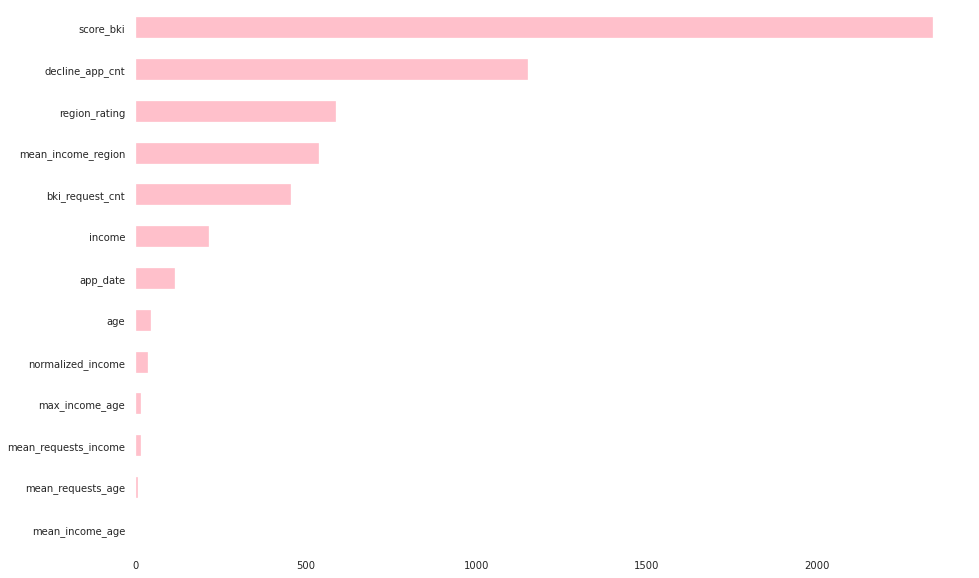

In [36]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='pink')

### ***Categorical and Binary***

<AxesSubplot:>

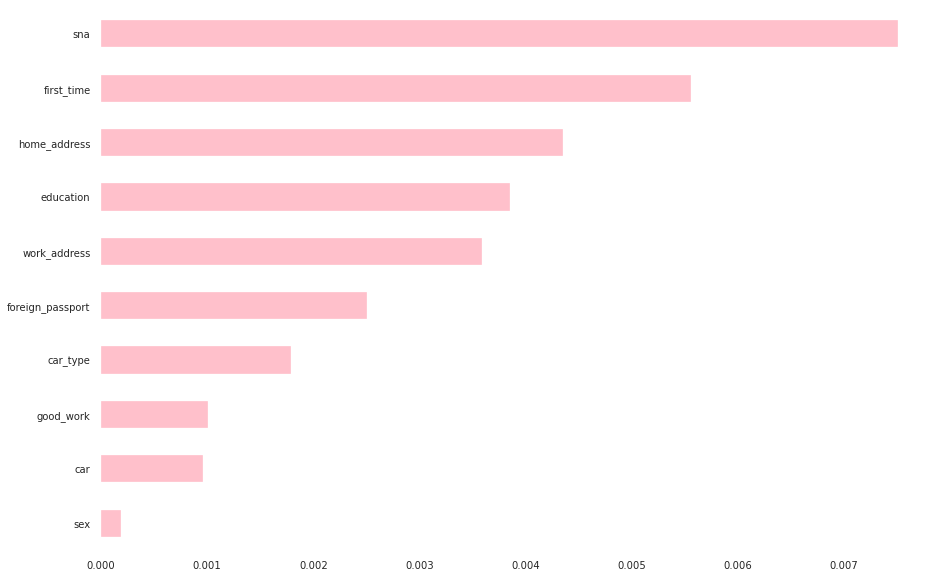

In [37]:
imp_cat = pd.Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color='pink')

## Encoding

In [38]:
df = pd.get_dummies(dataset, prefix=cat_cols, columns=cat_cols) # categorical dummies

In [39]:
data = df.copy()

In [40]:
data.head(3)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address_1,home_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3
0,25905,-0.934391,1,1.975219,1,1,-0.418815,0,-0.208688,-0.281790,...,0,0,0,0,0,1,1,0,0,0
1,63161,0.281474,0,1.714757,0,0,-0.418815,0,0.745419,0.770563,...,1,0,0,0,0,1,1,0,0,0
2,25887,-0.934391,1,-1.237142,1,0,2.621662,0,0.993988,-0.281790,...,0,0,1,0,0,0,0,0,0,1


# Modeling

In [41]:
train_df = df.query('sample == 1').drop(['sample','client_id'], axis=1)
test_df = df.query('sample == 0').drop(['sample','client_id'], axis=1)

In [42]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values # <--- target

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=69)

In [44]:
lr = LogisticRegression(max_iter = 1000)

In [45]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)

## **ROC AUC**

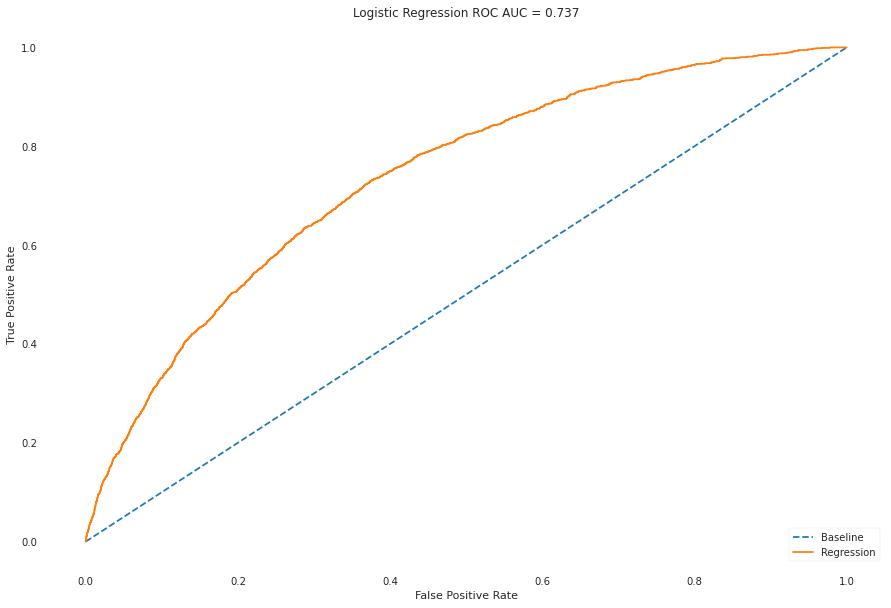

In [46]:
probs = lr.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Let's see if we can make it better

In [47]:
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

accuracy_score: 0.8726964769647696
precision_score: 0.504
recall_score: 0.03351063829787234
f1_score: 0.06284289276807979


Metrics show that in actuality, the model sucks

### Confusion matrix

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

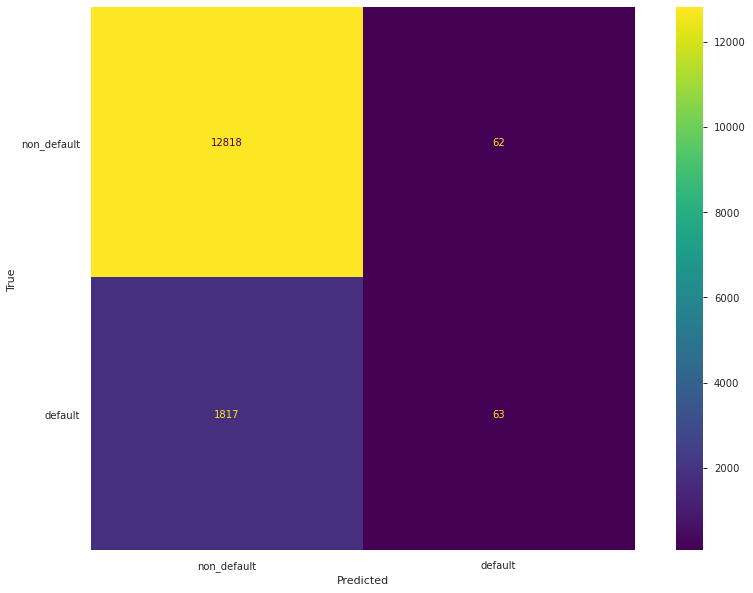

In [48]:
cm = confusion_matrix(y_valid, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

SHeeeesh.. our model will give out credit to practically everyone, that is not good, let's make it better by tweeking hyperparameters

# Tuning

In [49]:
train_df = df.query('sample == 1').drop(['sample','client_id'], axis=1)
test_df = df.query('sample == 0').drop(['sample','client_id'], axis=1)

In [50]:
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values # целевая переменная

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [52]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best Score:  0.731446655416028
Best Params:  {'C': 0.1, 'class_weight': {1: 0.7, 0: 0.3}, 'penalty': 'l2', 'solver': 'saga'}


## ROC AUC

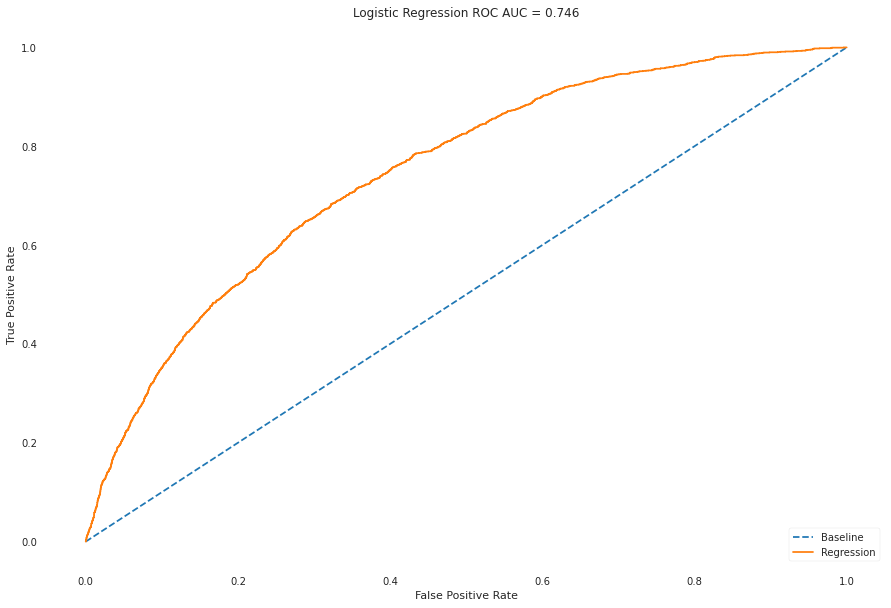

In [53]:
probs = lr.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

ROC AUC IS Much better

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

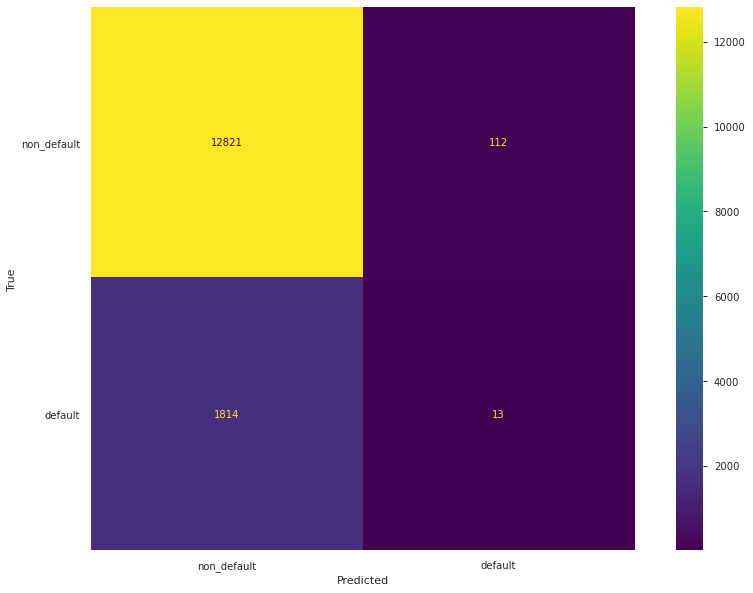

In [54]:
cm = confusion_matrix(y_valid, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [55]:
best_parameters = grid_result.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = grid_result.predict(X_valid)
print('Accuracy: %.4f' % accuracy_score(y_valid, preds))
print('Precision: %.4f' % precision_score(y_valid, preds))
print('Recall: %.4f' % recall_score(y_valid, preds))
print('F1: %.4f' % f1_score(y_valid, preds))

	cv: None
	error_score: nan
	estimator: LogisticRegression(max_iter=1000)
	estimator__C: 1.0
	estimator__class_weight: None
	estimator__dual: False
	estimator__fit_intercept: True
	estimator__intercept_scaling: 1
	estimator__l1_ratio: None
	estimator__max_iter: 1000
	estimator__multi_class: 'auto'
	estimator__n_jobs: None
	estimator__penalty: 'l2'
	estimator__random_state: None
	estimator__solver: 'lbfgs'
	estimator__tol: 0.0001
	estimator__verbose: 0
	estimator__warm_start: False
	n_jobs: -1
	param_grid: {'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{1: 0.5, 0: 0.5}, {1: 0.4, 0: 0.6}, {1: 0.6, 0: 0.4}, {1: 0.7, 0: 0.3}], 'solver': ['liblinear', 'saga']}
	pre_dispatch: '2*n_jobs'
	refit: True
	return_train_score: False
	scoring: 'roc_auc'
	verbose: 1
Accuracy: 0.8591
Precision: 0.3756
Recall: 0.2091
F1: 0.2686


### Use best_params_

In [56]:
best_model = LogisticRegression(random_state=69, C=0.1,  class_weight={1: 0.7, 0: 0.3},penalty='l2', solver='saga',warm_start=False,max_iter=1000)

best_model.fit(X_train, y_train)
y_pred_prob = best_model.predict_proba(X_valid)[:,1]
y_pred = best_model.predict(X_valid)

In [57]:
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

accuracy_score: 0.8590785907859079
precision_score: 0.37561455260570303
recall_score: 0.20908593322386426
f1_score: 0.2686357243319269


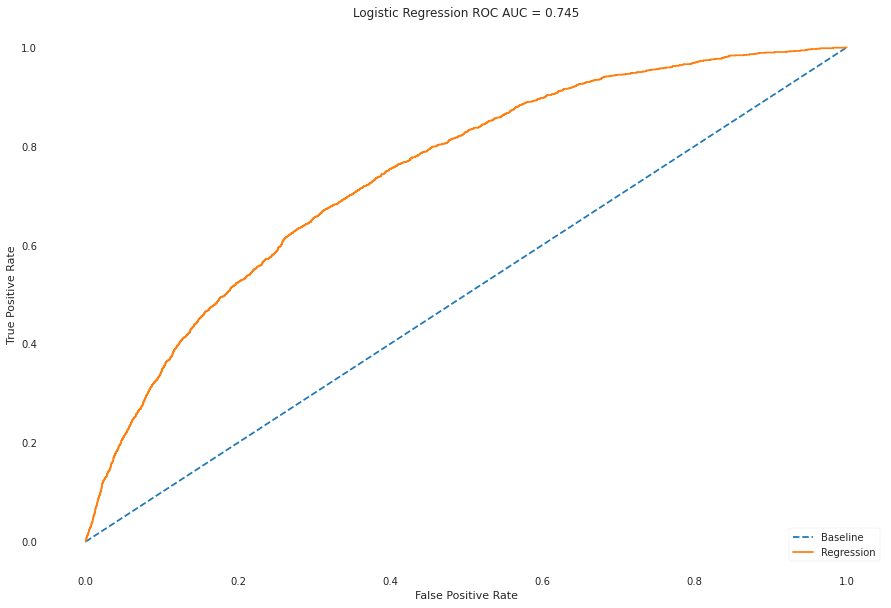

In [58]:
probs = best_model.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# SUBMISSION

In [59]:
train_data = data.query('sample == 1').drop(['sample','client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample','client_id'], axis=1)

In [60]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [61]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (73799,), (36349, 37))

In [62]:

y_pred_prob = grid_result.predict_proba(X_test)[:,1]
y_pred = grid_result.predict(X_test)

In [63]:
submit = pd.DataFrame(test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [64]:
display(submit)

,client_id,default
0,74835,0.085955
1,17527,0.580229
2,75683,0.134583
3,26883,0.180558
4,28862,0.058539
...,...,...
36344,83775,0.545338
36345,106254,0.035649
36346,81852,0.546248
36347,1971,0.372307
